In [1]:
import numpy as np
import os
import segyio
import pandas as pd

from pyfrac.visualisation.plotting_support import explode_volume

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# shaheen_incoming = '/home/birniece/Documents/Projects/MicroseismicModelling/ShaheenTransfers/INCOMING/'
# seispath = 'explosive_multishot/UtahFORGE_GriddedRecs_Pancake/outputs/su/'
# shotpath =  'explosive_multishot/UtahFORGE_GriddedRecs_Pancake/inputs/multishot_sources/'

In [3]:
shaheen_incoming = '/home/birniece/Documents/Projects/MicroseismicModelling/ShaheenTransfers/INCOMING/Shaheen3'
seispath = 'UtahFORGE_GriddedRecs_CroppedModel/outputs/su'
shotpath = 'UtahFORGE_GriddedRecs_CroppedModel/inputs/multishot_sources'
expname = 'multishot_group05'

# seispath = 'UtahFORGE_GriddedRecs_CroppedModel/UtahFORGE_GriddedRecs_CroppedModel/outputs/su/'
# expname = 'multishot_group00'

In [4]:
def traceimage(data, norm_indiv=False, figsize=[12, 6], cbar=True, clim=1, cmap='seismic', ax=None):
    if norm_indiv:
        data = (data.T / np.max(abs(data), axis=1)).T        

    # clim = np.percentile(abs(data), climQ)

    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    im = ax.imshow(data.T, aspect='auto', interpolation=None,
                   cmap=cmap, vmin=-1 * clim, vmax=clim)
    if cbar: plt.colorbar(im, ax=ax, label='Seis. Amp.')
    ax.set_xlabel('Receiver #')
    ax.set_ylabel('Time')
    ax.set_title('Seismic Recording')
    ax.axis('tight')
    if ax is None: fig.tight_layout()

    return ax

In [5]:
def read_seis(seisfile, nr):
    # s_wave_file = os.path.join(data_path,'test.bin.curl')
    seis_flat = np.loadtxt(seisfile)

    # determine number of timesamples and ensure it saved fully
    nt = int(seis_flat.shape[0] / nr)
    try:
        seis_flat.reshape((nr, nt))
    except:
        print('Not good dims \n nt:%i nr:%i \n vz flat:%i' % (nt, nr, seis_flat.shape[0]))

    # Resample to 2D
    seis = seis_flat[:nt * nr].reshape((nr, nt))
    return seis

--------------

In [6]:
ngroups = 45

In [7]:
nr = 169
nt = 1000
n_srcs = 100

In [8]:
# Setup array 
vz_data_full_grouped = np.zeros([ngroups, n_srcs, nr, 200])
vy_data_full_grouped = np.zeros([ngroups, n_srcs, nr, 200])
vx_data_full_grouped = np.zeros([ngroups, n_srcs, nr, 200])

loc_full_grouped = np.zeros([ngroups, n_srcs, 3])

In [9]:
noshot = 0
for g in range(ngroups):
    expname = 'multishot_group%.2i'%g

    vz = np.zeros([n_srcs, nr, nt])
    vy = np.zeros([n_srcs, nr, nt])
    vx = np.zeros([n_srcs, nr, nt])
    
    loc_g = np.zeros([n_srcs, nr, nt])
    
    for i,srcnum in enumerate(range(n_srcs)):    
        # READ SEISMIC
        try:
            vz[i]  = read_seis(os.path.join(shaheen_incoming,seispath,'%s_vz.txt.shot%i'%(expname,srcnum+1)), nr)
            vy[i]  = read_seis(os.path.join(shaheen_incoming,seispath,'%s_vy.txt.shot%i'%(expname,srcnum+1)), nr)
            vx[i]  = read_seis(os.path.join(shaheen_incoming,seispath,'%s_vx.txt.shot%i'%(expname,srcnum+1)), nr)
        except:
            # print('No Shot - ',expname)
            noshot += 1
            pass
        
        
    vz_data_full_grouped[g] = vz[:,:,550:750]
    vy_data_full_grouped[g] = vy[:,:,550:750]
    vx_data_full_grouped[g] = vx[:,:,550:750]
    
    # READ LOCATIONS
    locdf = pd.read_csv(os.path.join(shaheen_incoming,shotpath,expname)+'.dat', sep='\t', names=['x', 'z', 'y', 't0','fc','amp'] )
    loc_full_grouped[g] = np.transpose(np.array([locdf['x'], locdf['y'], locdf['z']]))
    

In [10]:
noshot

0

In [11]:
vz_data_full = vz_data_full_grouped.reshape(vz_data_full_grouped.shape[0]*vz_data_full_grouped.shape[1], nr, 200)
vy_data_full = vy_data_full_grouped.reshape(vy_data_full_grouped.shape[0]*vy_data_full_grouped.shape[1], nr, 200)
vx_data_full = vx_data_full_grouped.reshape(vx_data_full_grouped.shape[0]*vx_data_full_grouped.shape[1], nr, 200)

loc_full = loc_full_grouped.reshape(loc_full_grouped.shape[0]*loc_full_grouped.shape[1], 3)

/home/birniece/miniconda3/envs/pyfrac/lib/python3.9/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


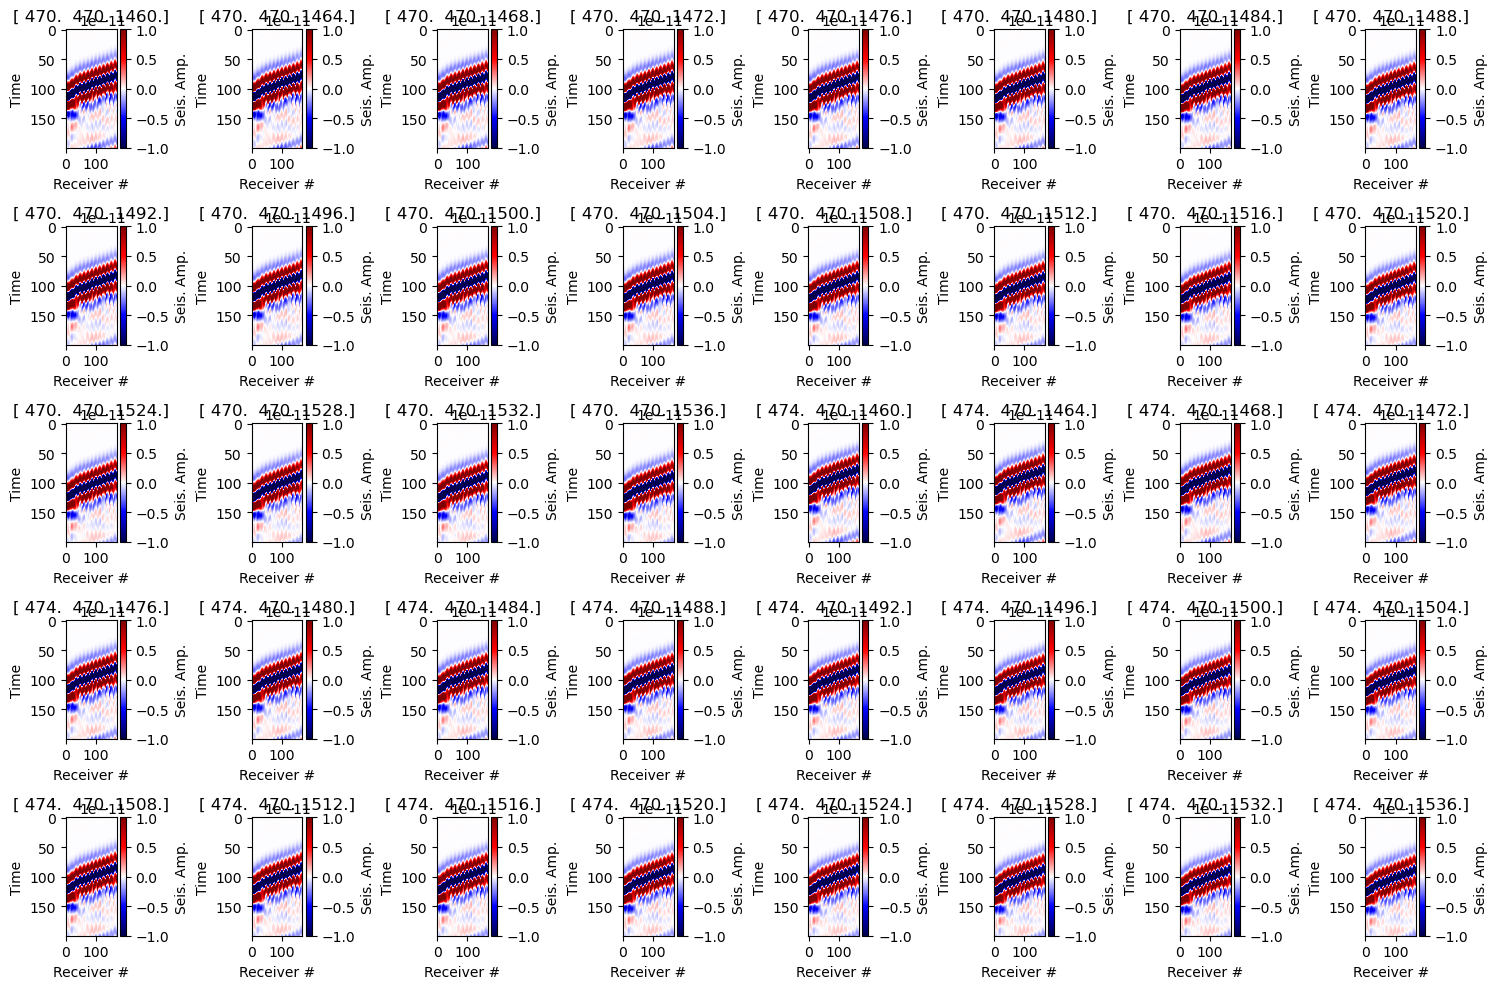

In [12]:
fig,axs = plt.subplots(5,8,figsize=[15,10])
for i in range(len(axs.ravel())):
    traceimage(vy_data_full[i],  clim=1e-11, ax=axs.ravel()[i])
    axs.ravel()[i].set_title(loc_full[i])
fig.tight_layout()

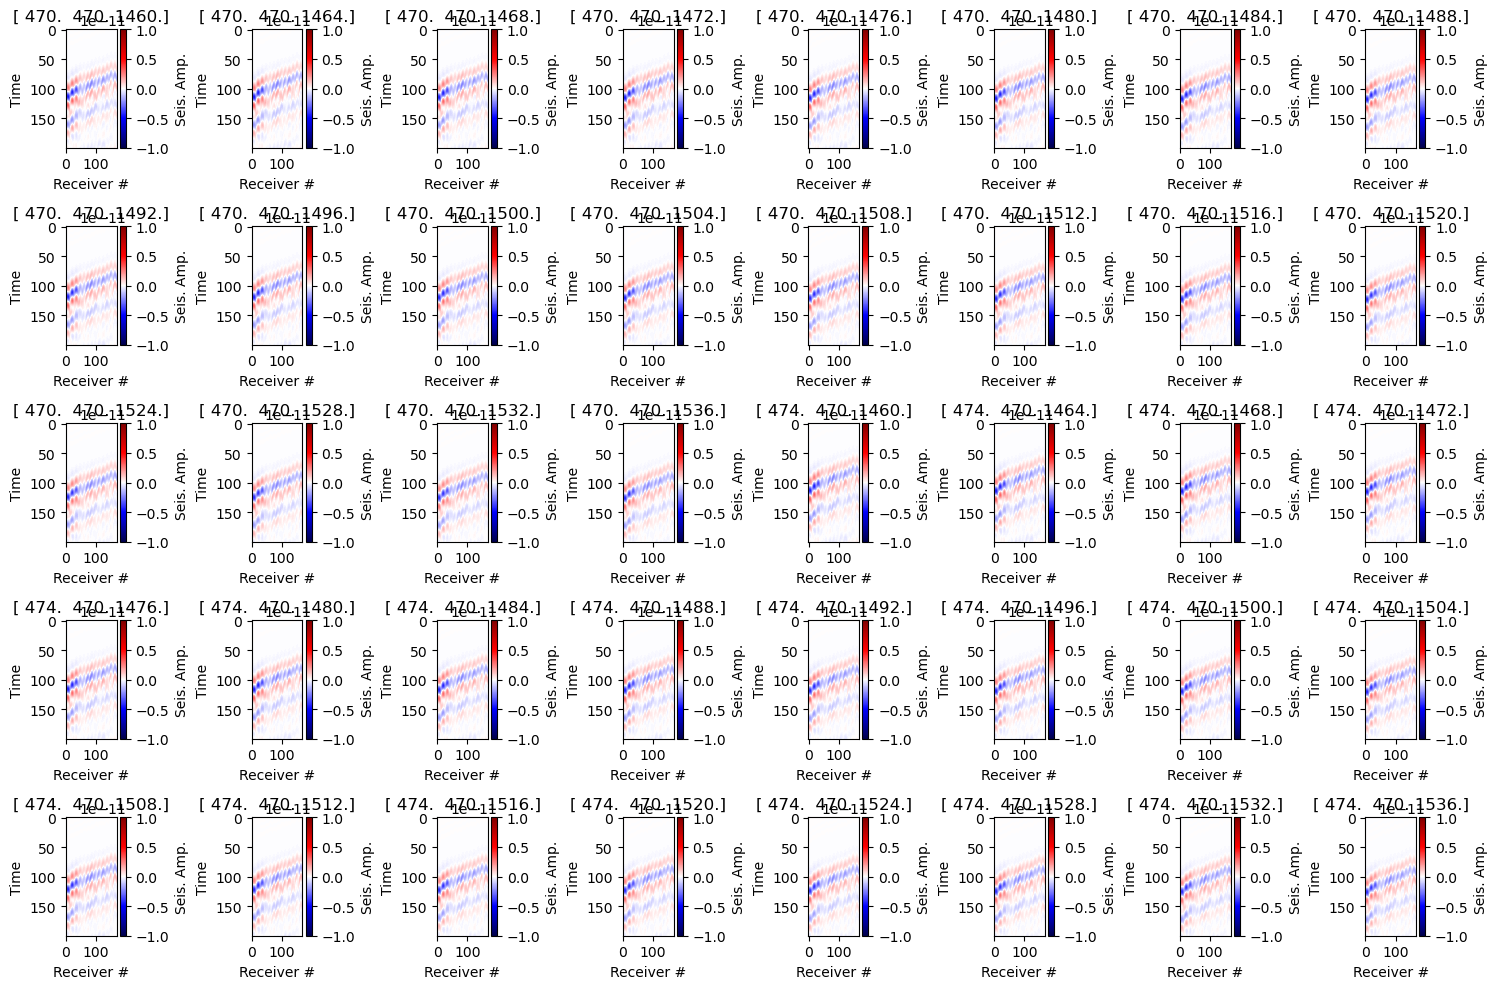

In [13]:
fig,axs = plt.subplots(5,8,figsize=[15,10])
for i in range(len(axs.ravel())):
    traceimage(vz_data_full[i],  clim=1e-11, ax=axs.ravel()[i])
    axs.ravel()[i].set_title(loc_full[i])
fig.tight_layout()

In [14]:
total_energy = np.sum(np.sum(np.array(vz_data_full), axis=2), axis=1)

In [15]:
len(np.where(total_energy==0)[0])

0

In [16]:
np.savez('/home/birniece/Documents/data/UTAH_FORGE/SyntheticData/GriddedRecs_CroppedSynths_wSourceLocs.npz',
         vx=vx_data_full,
         vy=vz_data_full,
         vz=vy_data_full,
         locations=loc_full
        )